<a href="https://colab.research.google.com/github/ludutram/LucianaDutra/blob/master/4___Atividade_Programa%C3%A7%C3%A3o_Din%C3%A2mica__Luciana_Dutra___enviado_dia_28_11_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Integrantes**

Enviado dia 28/11/2023



**202005469** - ALEX ECHEVERRIA

**202005490** - JOSE RAFAEL REBELO

**2020101453** - LUCAS ARAÚJO PEREIRA

**15008262** - LUCIANA DUTRA MARTINS

**202005504** - RAFAELA MOTA SILVA

**202005505** - RODRIGO MENDES DE CARVALHO


# **Programação Dinâmica**

In [1]:
import pprint
import numpy as np
import itertools
import matplotlib.pyplot as plt
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

## Agente e Ambiente

Dado o agente e o ambiente a seguir:

O espaço de ações é uma lista composta por **cima**, **baixo**, **esquerda** e **direita**. Possibilidades de movimento do agente ao longo do plano.

Os estados são representados por duas coordenadas. Um estado em si é uma lista com as coordenadas **[Y, X]** a troca em relação ao convencional (x,y) facilita a programação do ambiente.

Na imagem é possível ver as recompensas ao chegar em cada estado, sendo o estado verde TERMINAL. Os estados em cinza representam paredes, terreno não navegável pelo agente. Por fim, caso o agente não seja capaz de terminar o episódio chegando ao estado terminal, o mesmo termina a execução após 30 passos.

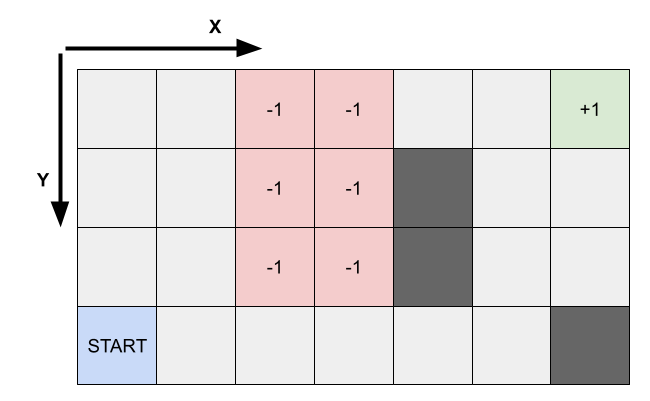

In [ ]:
# Algumas variáveis globais
UP, DOWN, LEFT, RIGHT = "UP", "DOWN", "LEFT", "RIGHT"
GRID_SHAPE = (4, 7)
UNICODE_ARROWS = {"UP": "\u2191", "DOWN": "\u2193", "LEFT": "\u2190", "RIGHT": "\u2192"}

In [ ]:
class Agent():
    def __init__(self, 
                 action_space, 
                #  grid_shape,
                 ):
      
        self.action_space = action_space
        self.policy = [ 
            [UP, UP, UP, UP, UP, UP, UP],
            [UP, UP, UP, UP, UP, UP, UP],
            [UP, UP, UP, UP, UP, UP, UP],
            [UP, UP, UP, UP, UP, UP, UP],
             ]
        # generic agent -------
        # self.policy = np.random.choice(self.action_space, size=grid_shape)

        self.v = np.array( [ 
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
             ] )
        # generic agent -------
        # self.v = np.zeros(shape=grid_shape)

    def choose_action(self, obs):
        
        action = self.policy[obs[0]][obs[1]]

        return action

    def show_value_function(self):
        fig, ax = plt.subplots()
        ax.set_title("V(s)")
        ax.matshow(self.v, cmap='winter')
        for (i, j), z in np.ndenumerate(self.v):
            ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
        # pprint.pprint(self.v)
        plt.show()

    def show_policy(self):
        fig, ax = plt.subplots()
        ax.set_title("pi(s)")
        ax.matshow(self.v, cmap="winter")
        for (i, j), z in np.ndenumerate(self.policy):
            ax.text(j, i, UNICODE_ARROWS[z], ha='center', va='center', fontsize="xx-large")
        # pprint.pprint(self.v)
        plt.show()


Inicialmente, para modelar o ambiente, foi levada em consideração a imagem citada acima para estabelecer os valores referentes às recompensas, além de definir os estados nos quais o agente se encontrar, estabelecendo barreiras com as paredes.

In [ ]:
class Environment():
    def __init__(self):

        self.start_state = [3, 0]
        self.action_space = [UP, DOWN, LEFT, RIGHT]
        self.current_state = self.start_state
        self.timestep = 0
        self.reward_function = np.array( [ 
            [0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 1.0],
            [0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, -1.0, -1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0],
             ] )
        self.walkable_terrain = np.array( [ 
            [True, True, True, True, True, True, True],
            [True, True, True, True, False, True, True],
            [True, True, True, True, False, True, True],
            [True, True, True, True, True, True, False],
             ] )
        self.terminal_states = [[0, 6]]
        
    def _transition_function(self, current_state, action):
        
        if action == "UP":
            desired_state = [current_state[0]-1, current_state[1]]
        elif action == "DOWN":
            desired_state = [current_state[0]+1, current_state[1]]
        elif action == "LEFT":
            desired_state = [current_state[0], current_state[1]-1]
        elif action == "RIGHT":
            desired_state = [current_state[0], current_state[1]+1]
        else:
            raise Exception("Action | {} | outside the action space".format(action))

        # Check if the desired state is inside the grid
        if ( desired_state[0] < self.walkable_terrain.shape[0] and
            desired_state[1] < self.walkable_terrain.shape[1] and
            desired_state[0] >= 0 and
            desired_state[1] >= 0  ):

            # Should the desired state be inside the grid, check if it's walkable
            if self.walkable_terrain[desired_state[0]][desired_state[1]]:
                current_state = desired_state

        # If neither condition is met then the state remains unchanged i.e. he bumped into a wall
        return current_state

    
    def step(self, action):
        action = str(action)
        self.current_state = self._transition_function(self.current_state, action)
        obs = self.current_state
        reward = self.reward_function[self.current_state[0]][self.current_state[1]]
        done = (self.current_state in self.terminal_states)
        info = {}
        self.timestep += 1
        if self.timestep >= 30:
            done = True
        
        return obs, reward, done, info

    def reset(self, custom_start=None):
        # !!! O custom_start não é usual e está presente aqui somente para realizar a 
        # avaliação de políticas exatamente como descrita na teoria

        if custom_start:
            self.current_state = custom_start
        else:
            self.current_state = self.start_state
        self.timestep = 0
        obs = self.current_state

        return obs

## Loop de Interação


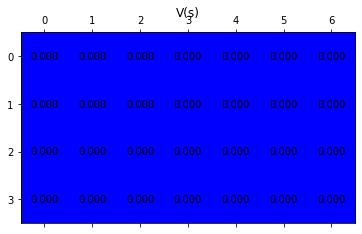

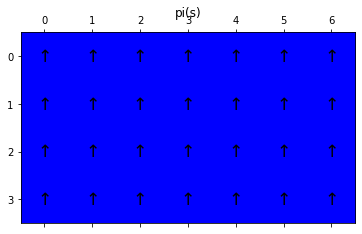

Trajectory:
[[3, 0], [2, 0], [1, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
['UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP', 'UP']


In [ ]:
# Inicializar ambiente
# Enquanto o epsidodio nao acabar
    # escolher ação
    # aplicar ação no ambiente
    # guardar transições

env = Environment()
agent = Agent(action_space=env.action_space)

states = []
actions = []
rewards = []

s = env.reset()
done = False
while not done:

    a = agent.choose_action(s)

    next_s, r, done, info = env.step(a)
    
    states.append(s)
    actions.append(a)
    rewards.append(r)

    s = next_s
    
agent.show_value_function()
agent.show_policy()
print("Trajectory:")
print(states)
print(actions)

## Atualização da Função Valor - *Policy Evaluation*

Atualize os valores da função de valor V(s) de acordo com a equação de Bellman e o algoritmo na imagem. Vale lembrar que, no ambiente atual, as probabilidades de mudança de estados e ação tomada pela política são sempre 100%.


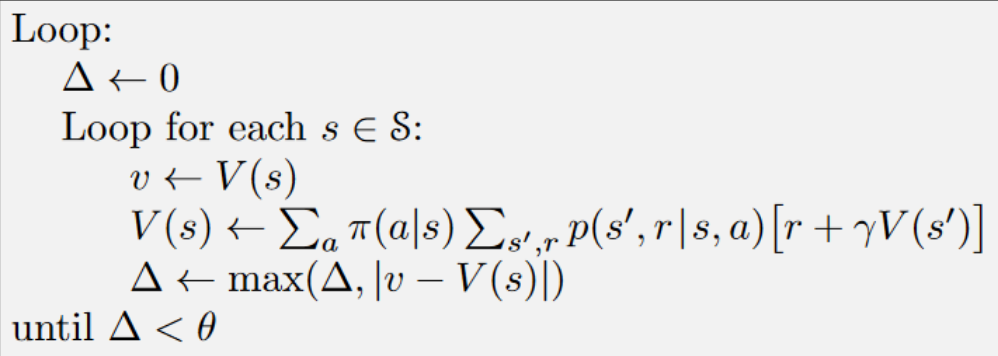

In [ ]:
# Para facilitar os experimentos, fazemos aqui uma lista de estados com todos os estados exceto o estado terminal
all_but_terminal = list(itertools.product(range(GRID_SHAPE[0]), range(GRID_SHAPE[1])))
all_but_terminal.remove((0,6))
# tirar paredes também
all_but_terminal.remove((1,4)) 
all_but_terminal.remove((2,4))
all_but_terminal.remove((3,6))

Devido ao fato de no ambiente atual, as probabilidades de mudança de estados e ação tomada pela política serem sempre 100%, é possível reduzir a equação apresentada acima em uma forma mais simples:

`V = r + GAMMA * agent.v[next_s[0], next_s[1]]`

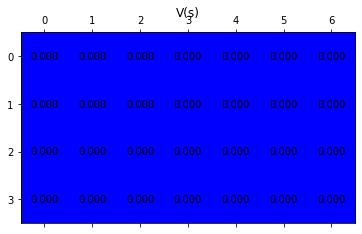

3.439
0.8999999999999999
0.81
0.7290000000000001
0.6561000000000003
0.59049
0.531441
0.47829690000000014
0.43046720999999977
0.38742048900000015
0.3486784401000005
0.3138105960899997
0.28242953648099967
0.25418658283289997
0.2287679245496097
0.20589113209465015
0.18530201888518505
0.16677181699666477
0.1500946352969983
0.13508517176729917
0.12157665459056943
0.10941898913151249
0.0984770902183616
0.08862938119652597
0.0797664430768723
0.0717897987691849
0.06461081889226605
0.05814973700304016
0.052334763302736675
0.047101286972463186
-------------------------------------------


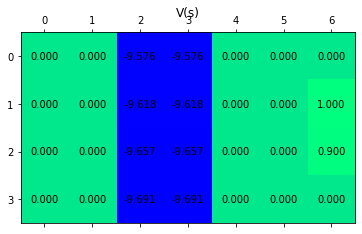

Number of Loops
30
[3, 5]
UP
0.0


In [ ]:
env = Environment()
agent = Agent(action_space=env.action_space)

# agent.show_value_function()
# agent.show_policy()

agent.show_value_function()
GAMMA = 0.9
THETA = 0.05
stable = False
n_loops = 0
while not stable:

    delta = 0 # Definição do valor inicial de Delta para cada estado

    for y, x in all_but_terminal: #loop em estados 
        old_v = agent.v[y][x] # Acesso à matriz de valores
        s = env.reset(custom_start=[y,x]) # o custom start permite iniciar em um estado que desejarmos
        a = agent.choose_action(s)
        next_s, r, done, info = env.step(a)
        # print(next_s)

        # Faça o seu código no espaço abaixo --------------------
        V = r + GAMMA * agent.v[next_s[0], next_s[1]]
        agent.v[s[0],s[1]] = V
        
        delta = max(delta, abs(V - old_v))
        # -------------------------------------------------------
    print(delta)
    if delta < THETA:
        stable = True
    n_loops+=1

print("-------------------------------------------")
agent.show_value_function()
print("Number of Loops")
print(n_loops)
print(s)
print(a)
print(r)

## Melhora de Política *Policy Improvement*
Faça um código que execute um único loop (por todos os estados) de melhora da política seguindo o algoritmo na imagem.

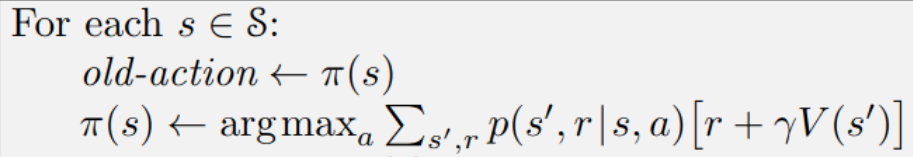

Cada ação no espaço de ações terá seu valor calculado com base na equação obtida anteriormente. Esse resultado será utilizado para definir qual é a melhor ação a ser tomada em cada estado na lista de estados, atualizando a política.

A partir daqui, fica mais perceptível o quanto as mudanças efetuadas afetam no desempenho do agente. Um dos primeiros pontos a ser ressaltado é a "fuga" perceptível nas regiões cuja recompensa é `-1.0` e a sutil preferência por estados mais próximos do estado terminal nas colunas mais à direita.

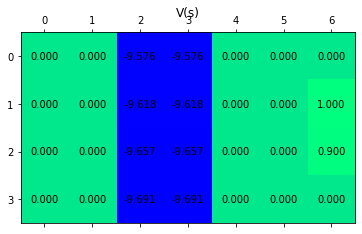

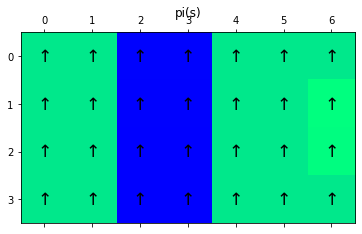

-------------------------------------------


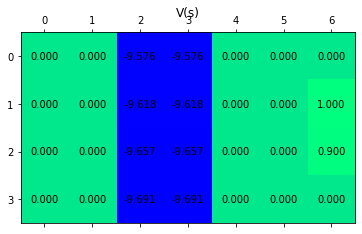

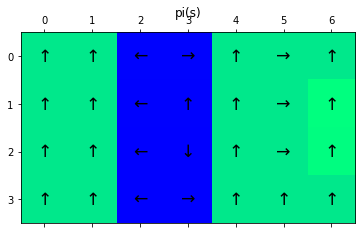

In [ ]:
# Mudar política para escolher estados com melhor retorno

# dado um estado, esta função retorna um dicionário no formato: {ação: valor da equação de Bellman}
def check_neighbors(state):
    action_values = {}
    for a in agent.action_space: #loop em ações
        s = env.reset(custom_start=state)
        next_s, r, done, info = env.step(a)
        # Faça o seu código no espaço abaixo --------------------
        action_values[a] = r + GAMMA * agent.v[next_s[0], next_s[1]]
        # -------------------------------------------------------
    return action_values


agent.show_value_function()
agent.show_policy()

for y, x in all_but_terminal: #loop em estados 
    values = check_neighbors([y, x])
    # Faça o seu código no espaço abaixo --------------------
    best_action = max(values, key=values.get)
    agent.policy[y][x] = best_action
    # -------------------------------------------------------


print("-------------------------------------------")
agent.show_value_function()
agent.show_policy()

## Iteração de Política *Policy Iteration*

Produza um algoritmo que itere sobre uma política fazendo avaliação e melhoria até sua convergência seguindo o algoritmo descrito na imagem.


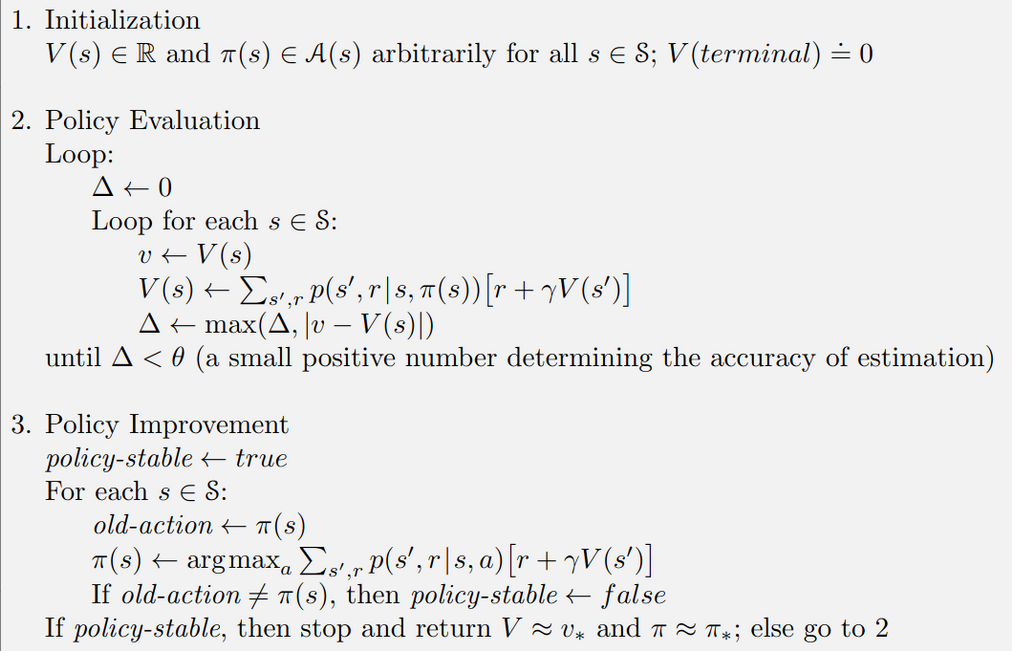

Com esse algoritmo, finalmente é possível atualizar os valores da política de modo que não seja levado em conta somente a recompensa imediata de um estado, mas também em suas redondezas. 

Dessa forma, o caminho estabelecido de acordo com os valores finais obtidos levam ao caminho ótimo para chegar no objetivo final.

In [ ]:
env = Environment()
agent = Agent(action_space=env.action_space)


# Faça o seu código no espaço abaixo --------------------

def policy_iteration(agent, env):
  GAMMA = 0.9
  THETA = 0.01
  n_iters = 0
  done = False
  
  while done is not True:
    stable = False
      
    while stable is not True:
      delta = 0

      for y, x in all_but_terminal:
        old_v = agent.v[y][x]
        s = env.reset(custom_start=[y,x]) 
        a = agent.choose_action(s)
        next_s, r, done, info = env.step(a)

        V = r + GAMMA * agent.v[next_s[0], next_s[1]]
        agent.v[s[0], s[1]] = V
        
        delta = max(delta, abs(old_v - V))

      if delta < THETA:
        stable = True

    policy_stable = True
    for y, x in all_but_terminal:
      old_action = agent.policy[y][x]
      values = check_neighbors([y, x])
      best_action = max(values, key=values.get)
      agent.policy[y][x] = best_action
      
      if old_action != agent.policy[y][x]:
        policy_stable = False

    if policy_stable is True:
      done = True
# -------------------------------------------------------
 
# Exiba por aqui a função de valor e política para cada passo de iteração
    n_iters+=1
    if n_iters%1 == 0:
        print("--({})--------------------".format(n_iters))
        agent.show_value_function()
        agent.show_policy()

        
# print("converged to:")
# agent.show_value_function()
# agent.show_policy()

--(1)--------------------


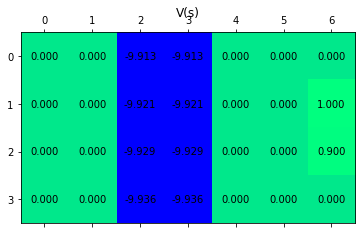

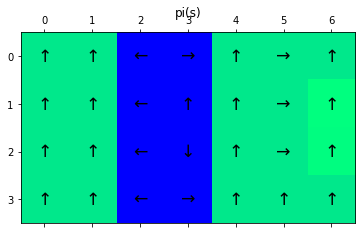

--(2)--------------------


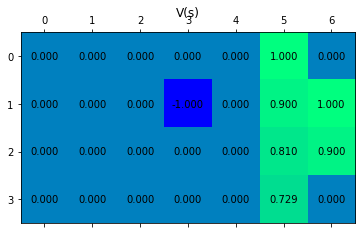

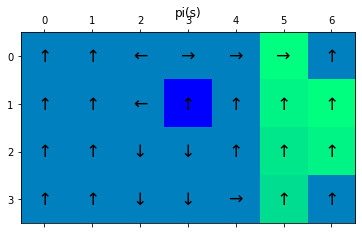

--(3)--------------------


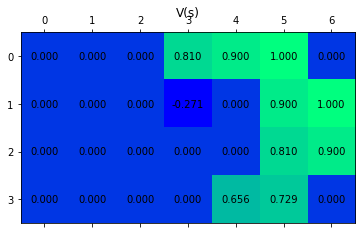

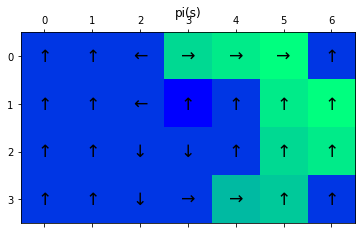

--(4)--------------------


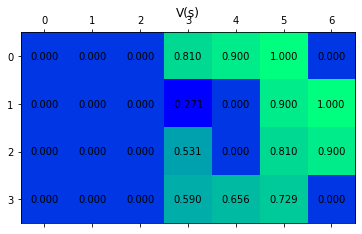

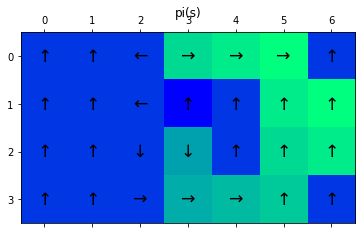

--(5)--------------------


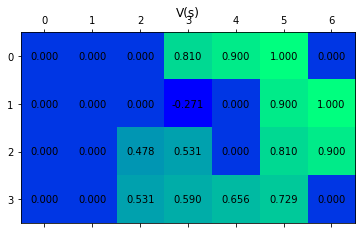

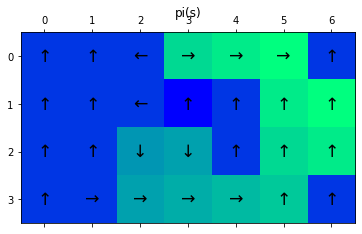

--(6)--------------------


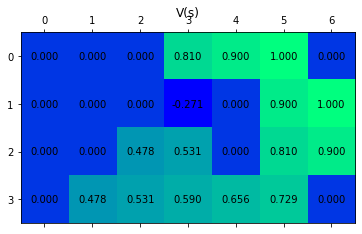

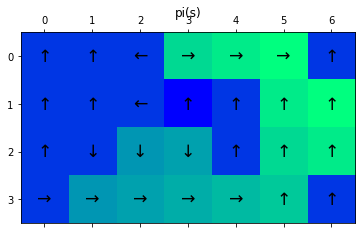

--(7)--------------------


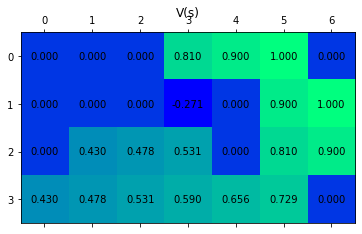

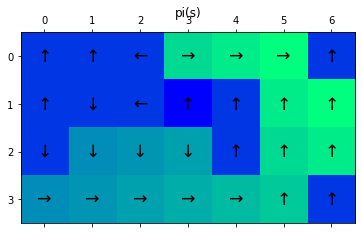

--(8)--------------------


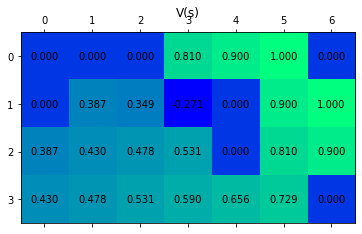

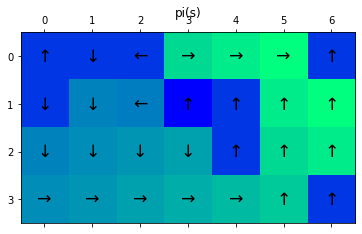

--(9)--------------------


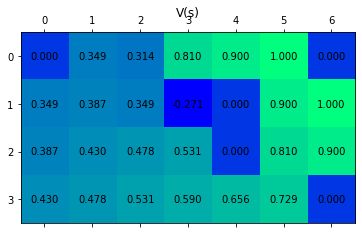

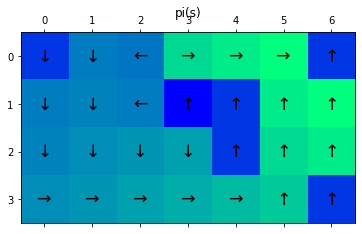

--(10)--------------------


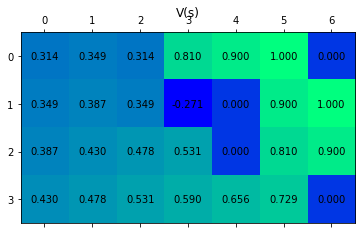

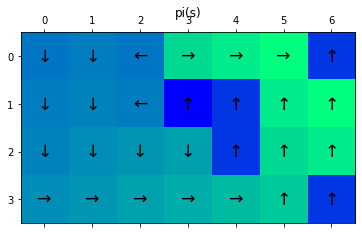

In [ ]:
policy_iteration(agent, env)